<a href="https://colab.research.google.com/github/J0han-ai/fast.ai/blob/main/PytorchCallback%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [26]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.3.20 installed.
fastai version 2.4 installed.


Pytorch to fastai, Bridging the Gap
Понимание того, как перенести код Pytorch в пространство fastai 

Feb 14, 2021 - 4 min read




Эта статья также представляет собой Jupyter Notebook, доступный для запуска сверху вниз. В нем будут фрагменты кода, которые вы сможете запустить в любой среде.
Ниже приведены версии fastai, fastcore, torch и torchvision, работающие на момент написания этой статьи:
fastai: 2.2.5
fastcore: 1.3.19
torch: 1.7.0+cu101
torchvision: 0.8.1+cu101

Решение проблемы "слона в комнате
Недавно я опубликовал твит с вопросом о том, с чем люди больше всего сталкиваются в fastai, и самым популярным ответом был вопрос о том, как минимально интегрироваться с Pytorch. Похоже, сложилось впечатление, что для использования fastai нужно использовать только полный fastai API, и ничего больше.
Давайте сейчас развеем это заблуждение:
  Важно: fastai по своей сути - это цикл обучения, разработанный для того, чтобы быть независимым от фреймворка. Вы можете использовать любую версию Pytorch, какую захотите, и использовать fastai только для быстрого и эффективного обучения модели с использованием самых современных методов.
План
Теперь, когда все заблуждения устранены, давайте рассмотрим, как это должно происходить. Мы будем следовать официальному руководству Pytorch CIFAR10 и покажем, что минимально необходимо сделать во фреймворке fastai, чтобы использовать все преимущества Learner. Это будет включать в себя:
Набор данных
Загрузчики данных
Модель
Оптимизатор
Набор данных и загрузчики данных
Следуя руководству, мы загрузим набор данных, используя только torchvision. Сначала мы возьмем наши импорты:


In [27]:
import torch
import torchvision
import torchvision.transforms as transforms


Далее мы определим некоторые минимальные преобразования:

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


In [29]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt

Далее мы определим некоторые минимальные преобразования:


In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])



Перед загрузкой наших обучающего и тестового наборов:
 Примечание: я использую соглашения об именовании, аналогичные тому, как fastai называет вещи, так что вы можете видеть, как они могут быть связаны друг с другом


In [31]:
dset_train = torchvision.datasets.CIFAR10(root='content/cifar10', train=True,
                                        download=True, transform=transform)
 

Files already downloaded and verified


In [32]:
dset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified


Files already downloaded and verified
Next we'll make our Dataloaders:

In [33]:
trainloader = torch.utils.data.DataLoader(dset_train, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(dset_test, batch_size=4,
                                         shuffle=False, num_workers=2)
 

И на этом мы пока остановимся, перейдем к следующей модели
Модель
Мы возьмем архитектуру из учебника и используем ее здесь:


In [34]:
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


И наконец, мы создадим его экземпляр:


In [35]:
net = Net()


Функция потерь и оптимизатор
Далее мы введем их функцию потерь и оптимизатор.
Функция потерь достаточно проста:


In [36]:
criterion = nn.CrossEntropyLoss()


Однако оптимизатор требует немного магии fastai, в частности, в виде OptimWrapper. Наша функция оптимизатора должна быть определена следующим образом

In [37]:
from fastai.optimizer import OptimWrapper
from torch import optim
 


In [38]:
def opt_func(params, **kwargs): return OptimWrapper(optim.SGD(params, lr=0.001))


Обучение
Теперь у нас есть все необходимое для обучения модели, так что теперь давайте запустим цикл обучения fastai, также известный как Learner.
 Learner fastai ожидает, что будут использоваться DataLoader'ы, а не просто один DataLoader, поэтому давайте сделаем так:
 Примечание: fastai также ожидает присутствия валидационного DataLoader, поэтому мы будем привязывать сюда тестовый загрузчик


In [39]:
from fastai.data.core import DataLoaders
 
dls = DataLoaders(trainloader, testloader)


In [40]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [41]:
#export
from fastai.basics import *

In [42]:
#hide
from nbdev.showdoc import *
from fastai.test_utils import *

In [43]:
#export
class CollectDataCallback(Callback):
    "Collect all batches, along with `pred` and `loss`, into `self.data`. Mainly for testing"
    def before_fit(self): self.data = L()
    def after_batch(self): 
        self.data.append(self.learn.to_detach((self.xb,self.yb,self.pred,self.loss)))

Наконец, мы собираемся завершить все это в Learner. Как уже упоминалось, Learner - это клей, который соединяет все вместе и позволяет пользователям использовать политику Лесли Смит "Один цикл", поиск скорости обучения и другие преимущества обучения fastai.
Давайте создадим его, передав наши dls, модель, оптимизатор и функцию потерь:


In [44]:
from fastai.learner import Learner

Чтобы получить причудливо выглядящий прогресс-бар fastai, нам нужно импортировать ProgressCallback:


In [45]:
from fastai.callback.progress import ProgressCallback


In [46]:
# Move the model to GPU if available & initialize the weights & biases:
if torch.cuda.is_available():
    myresnet34.to(device = 'cuda')
kaiming_init(myresnet34)

NameError: ignored

In [ ]:
doc(Learner)

In [ ]:
learn = Learner(dls, model=myresnet34)

In [ ]:
# Loss function obtained from training dataset
dls.train_ds.loss_func

In [ ]:
# Default Callbacks
learn.cbs

In [ ]:
# Sorting order for Callbacks
sort_by_run(learn.cbs)

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.5848931980144698e-06)

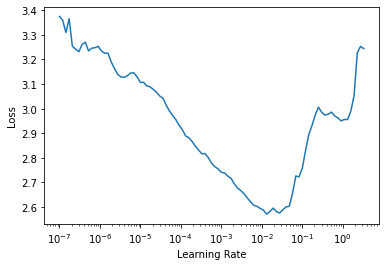

In [ ]:
learn.lr_find()

Нам также нужно передать CudaCallback, чтобы наши пакеты можно было переместить на GPU (DataLoaders в fastai может сделать это автоматически).


In [ ]:
from fastai.callback.data import CudaCallback
 
learn = Learner(dls, net, loss_func=criterion, opt_func=opt_func, cbs=[CudaCallback])
 


Наконец, давайте проведем минимальную тренировку.
Теперь у нас есть все необходимое для базовой подгонки:
 Примечание: Поскольку мы уже передали скорость обучения в Learner, нам не нужно передавать ее здесь.


In [ ]:
learn.fit(2)

Что дальше?
Отлично, теперь мы обучили нашу модель, но что нам с ней делать? Как ее вывести?
Ваша модель находится в learn.model, и мы уже видели, что ранее мы передали обычную модель Pytorch. Поскольку мы используем базовый класс Learner из fastai, сама модель не была изменена. В результате, это все еще обычная модель Pytorch, которую мы можем сохранить:


In [ ]:
torch.save(learn.model.state_dict(), './cifar_net.pth')


И это действительно все! Как вы можете видеть, минимальное, что вы можете получить при использовании фреймворка fastai, это:
Pytorch DataLoader
Pytorch model
fastai Learner
fastai Optimizer
Заключительные замечания
Я надеюсь, что это просветило вас о том, насколько гибким может быть фреймворк fastai для ваших учебных нужд с идеалистической целью просто получить модель.
Поскольку мы убрали большую часть  framework fastai, с этого момента вы должны использовать стандартный Pytorch, так как специфические для fastai функции, такие как test_dl и predict, больше не смогут быть использованы, поскольку вы не использовали fastai DataLoader.
Спасибо, что читаете!
